In [1]:
from bigbang.archive import Archive
import bigbang.analysis.utils as utils
import matplotlib.pyplot as plt
import pandas as pd
import re

## Preparing the data

Open a mailing list archive.

In [2]:
arx = Archive("httpbisa", mbox=True)

/home/sb/projects/bigbang/bigbang/mailman.py:141: UserWarning: No mailing list name found at httpbisa
  warnings.warn("No mailing list name found at %s" % url)


We will need to extract email addresses and email domains from the `From` field of the emails.

In [3]:
email_regex = r"[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+"
domain_regex = r"[@]([a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)$"

email = re.search(email_regex, "Gerald Oskoboiny <gerald@w3.org>")[0]
re.search(domain_regex, email)[1]

'w3.org'

We can break down all the emails sent to the mailing list by domain.

In [4]:
arx.data["From"].apply(utils.extract_domain).value_counts().head(15)

gmail.com              6709
mnot.net               4372
gmx.de                 3724
1wt.eu                 1549
phk.freebsd.dk         1242
treenet.co.nz          1028
qbik.com                854
ietf.org                814
google.com              792
henriknordstrom.net     790
gbiv.com                727
chromium.org            714
microsoft.com           647
intalio.com             420
apple.com               417
Name: From, dtype: int64

We can see that there are some generic email domains (gmail.com), some personal email domains (mnot.net), and some corporate email domains (google.com, apple.com). If we are interested in organizations, we need to identify domains that represent collections of people representing a single organization. How can we find that out?

## Defining Domain Entropy

In [5]:
froms = arx.get_personal_headers()

In [6]:
froms.head(10)

,From,email,domain
Message-ID,,,
<20020412162821.GA21015@w3.org>,Gerald Oskoboiny <gerald@w3.org>,gerald@w3.org,w3.org
<009901c1e5b5$07513b90$71432099@larrypad>,"""Larry Masinter"" <LMM@acm.org>",lmm@acm.org,acm.org
<20020423124259.Y20848@www.markbaker.ca>,Mark Baker <distobj@acm.org>,distobj@acm.org,acm.org
<82ofg99bld.fsf@dhcp74.ma.virata.com>,Scott Lawrence <lawrence@world.std.com>,lawrence@world.std.com,world.std.com
<62E4D97E-57BF-11D6-87D7-000393753936@apache.org>,"""Roy T. Fielding"" <fielding@apache.org>",fielding@apache.org,apache.org
<79107D208BA38C45A4E45F62673A434D07371BCD@red-msg-07.redmond.corp.microsoft.com>,"""Henrik Frystyk Nielsen"" <henrikn@microsoft.com>",henrikn@microsoft.com,microsoft.com
<002001c1ebe3$98411470$77432099@larrypad>,"""Larry Masinter"" <LMM@acm.org>",lmm@acm.org,acm.org
<F71FB682-57E1-11D6-87D7-000393753936@apache.org>,"""Roy T. Fielding"" <fielding@apache.org>",fielding@apache.org,apache.org
<20020424213946.D20848@www.markbaker.ca>,Mark Baker <distobj@acm.org>,distobj@acm.org,acm.org


In order to evaluate the extent to which a domain represents (a) and individual, (b) a set of organized individuals, or (c) a large set of unorganized individuals, we will measure the concentration of the distribution of email addresses per domain.

If $n_D$ is the number of messages from domain $D$, and $n_e$ is the number of messages from email address $e$, then we will compute the information entropy of the frequency of $e$ in $D$.

$$H(D) = - \sum_{e \in D} \frac{n_e}{n_D} \log \frac{n_e}{n_D}$$

Using metric, we can now see that Mark Nottingham's personal domain `mnot.net` has lower domain entropy than the company Apple's domain `apple.com`, which has lower domain entropy than the generic personal domain `gmail.com`.

In [7]:
utils.domain_entropy("mnot.net", froms)

0.18370277742404256

In [8]:
utils.domain_entropy("apple.com", froms)

1.2903640226801691

In [9]:
utils.domain_entropy("gmail.com", froms)

3.045345020841495

## Using the metric

We can compute the domain entropy for all domains and plot these values.

In [10]:
domains = froms["domain"].unique()

In [11]:
domain_entropies = pd.Series(
    index=domains, data=[utils.domain_entropy(dom, froms) for dom in domains]
)
domain_entropies = domain_entropies.sort_values(ascending=False)

Text(0.5, 1.0, 'Within Mailing List Domain Entropy')

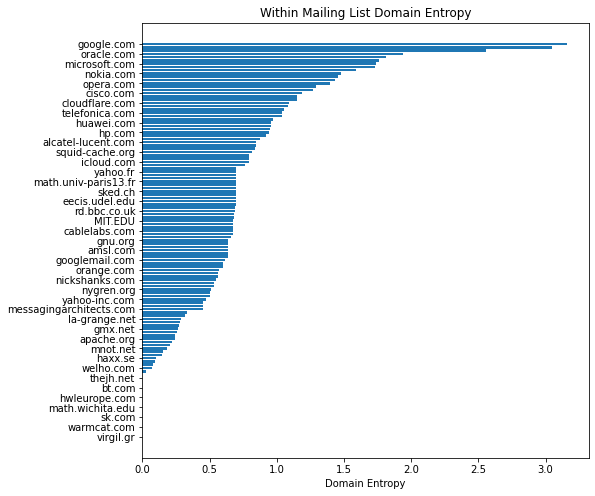

In [12]:
import numpy as np

y_limit = 121
dom_ent = domain_entropies.head(y_limit)

fig, ax = plt.subplots(figsize=(8, 8))

domains = dom_ent.index
y_pos = np.arange(len(domains))

ax.barh(y_pos, dom_ent.values)

ax.set_yticks(y_pos[::3])
ax.set_yticklabels(domains[::3])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Domain Entropy")
ax.set_title("Within Mailing List Domain Entropy")

The most surprising thing about this metric is that the generic email domain `gmail.com` has less entropy than the corporate domain `google.com`. Why is that?

In [13]:
domain_entropies.head(20)

google.com         3.162711
gmail.com          3.045345
hotmail.com        2.553237
oracle.com         1.939188
yahoo.com          1.814037
w3.org             1.758979
microsoft.com      1.740491
ericsson.com       1.731023
akamai.com         1.585919
nokia.com          1.475076
fb.com             1.457502
us.ibm.com         1.430280
opera.com          1.395972
apple.com          1.290364
maebashi-it.org    1.273028
cisco.com          1.187929
amazon.com         1.152774
chromium.org       1.151040
cloudflare.com     1.088900
acm.org            1.081088
dtype: float64

It looks like the `gmail.com` domain is dominated by a few major individuals, whereas the `google.com` representation is smaller overall, and more evenly distributed across their team members.

In [14]:
froms[froms["domain"] == "gmail.com"]["email"].value_counts().head(10)

martin.thomson@gmail.com      2021
grmocg@gmail.com               973
jasnell@gmail.com              829
zhong.j.yu@gmail.com           233
kazuhooku@gmail.com            211
bizzbyster@gmail.com           186
tatsuhiro.t@gmail.com          164
lucaspardue.24.7@gmail.com     159
hallam@gmail.com               152
potswa@gmail.com               132
Name: email, dtype: int64

<AxesSubplot:>

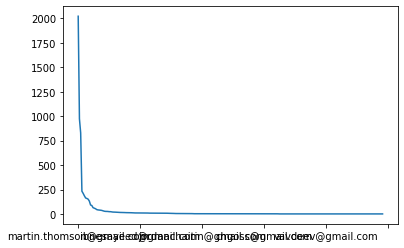

In [15]:
froms[froms["domain"] == "gmail.com"]["email"].value_counts().plot()

In [16]:
froms[froms["domain"] == "google.com"]["email"].value_counts().head(10)

rch@google.com         105
mkwst@google.com       101
bemasc@google.com       59
wenboz@google.com       58
akalin@google.com       47
yhirano@google.com      45
estark@google.com       45
jyasskin@google.com     41
tyoshino@google.com     41
ianswett@google.com     34
Name: email, dtype: int64

<AxesSubplot:>

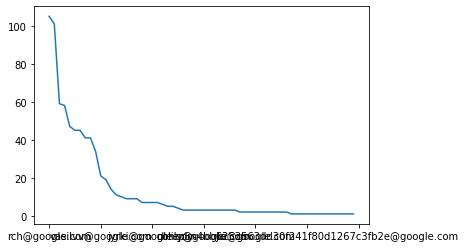

In [17]:
froms[froms["domain"] == "google.com"]["email"].value_counts().plot()